In [38]:
import pandas as pd
import pandasql as ps
import pyodbc
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import categorical_accuracy
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM
from keras.layers import GlobalMaxPool1D, Conv1D, Dropout, GRU, Flatten, MaxPooling1D
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image 
from io import StringIO
import pydotplus
%matplotlib inline

In [39]:
#Grab data from a database

def getData(Server, UID, PWD, Database, query):    
    
    #create a SQL connection based on the given server and database
    sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                              'SERVER='+Server+';' 
                              'UID='+UID+';'
                              'PWD='+PWD+';'
                              'DATABASE='+Database+';' )
    
    #return the data from the given Query and SQL connection,
    return pd.read_sql(query, sql_conn)

In [40]:
#establish my server and corresponding database to pull data from
server ='GSDEMO2HOST'
database = 'MClinical'
UID = 'gsanalytics'
PWD = 'G3st@lt'


#CREATE CARTESIAN PRODUCT OF THE 4 PARAMETERS, APPLY OUR ALGORITHM TO THE CARTESIAN PRODUCT AND TEST
query ="select input.locationName, input.fillerOrderStatusCd, input.scheduledGroups, input.subSpecialtyCd, CASE WHEN ISNULL(input.subSpecialtyCd, 'UNKNOWN') = '*GYP' AND input.locationName LIKE '%SPOKANE%' AND input.scheduledGroups = '1' AND input.fillerOrderStatusCd LIKE '%F%' THEN 1 WHEN ISNULL(input.subSpecialtyCd, 'UNKNOWN') NOT LIKE '*GYP' AND input.locationName LIKE '%SPOKANE%' AND input.scheduledGroups = '3' THEN 2 WHEN ISNULL(input.subSpecialtyCd, 'UNKNOWN') LIKE '*GYP' AND input.locationName LIKE '%SPOKANE%' THEN 3 WHEN ISNULL(input.subSpecialtyCd, 'UNKNOWN') LIKE '*GP' AND input.locationName LIKE '%BELLEVUE%' AND input.scheduledGroups = '3' AND input.fillerOrderStatusCd LIKE '%F%' THEN 4 WHEN ISNULL(input.subSpecialtyCd, 'UNKNOWN') LIKE '*GYP' AND input.locationName LIKE '%BELLEVUE%' AND input.scheduledGroups = '1' AND input.fillerOrderStatusCd LIKE '%C%' THEN 5 WHEN ISNULL(input.subSpecialtyCd, 'UNKNOWN') LIKE '*GYP' AND input.locationName LIKE '%BELLEVUE%' AND input.scheduledGroups = '1' AND input.fillerOrderStatusCd LIKE '%F%' THEN 6 WHEN input.locationName LIKE '%BELLEVUE%' THEN 7 WHEN input.locationName LIKE '%SPOKANE%' THEN 8 WHEN input.scheduledGroups = '1' THEN 9 WHEN input.scheduledGroups = '2' OR input.scheduledGroups = '3' OR input.scheduledGroups = '4' THEN 10 WHEN input.scheduledGroups = '5' OR input.scheduledGroups = '6' OR input.scheduledGroups = '7' OR input.scheduledGroups = '8' THEN 11 ELSE 12 END as bucketName from ( select fo.locationName, status.fillerOrderStatusCd, scheduled.scheduledGroups, ps.subSpecialtyCd from ( SELECT DISTINCT ISNULL( ProcedureStep.subSpecialtyCd, 'UNKNOWN' ) as subSpecialtyCd FROM ProcedureStep ) as ps, ( SELECT DISTINCT ISNULL(PL.locationName, 'UNKNOWN') as locationName FROM FillerOrder LEFT JOIN LOCATION AS PL ON FillerOrder.scheduledLocationKey = PL.locationKey ) as fo, ( SELECT DISTINCT FillerOrder.fillerOrderStatusCd FROM FillerOrder ) as status, ( select distinct fo.scheduledGroups as scheduledGroups from ( select case when DATEDIFF(DAY, scheduled, GETDATE()) <= 465 then 1 when DATEDIFF(DAY, scheduled, GETDATE()) <= 562 then 2 when DATEDIFF(DAY, scheduled, GETDATE()) <= 664 then 3 when DATEDIFF(DAY, scheduled, GETDATE()) <= 762 then 4 when DATEDIFF(DAY, scheduled, GETDATE()) <= 860 then 5 when DATEDIFF(DAY, scheduled, GETDATE()) <= 955 then 6 when DATEDIFF(DAY, scheduled, GETDATE()) <= 1056 then 7 when DATEDIFF(DAY, scheduled, GETDATE()) <= 1153 then 8 when DATEDIFF(DAY, scheduled, GETDATE()) <= 1247 then 9 else 10 end as scheduledGroups from fillerorder ) as fo ) as Scheduled ) as input order by bucketName"
original = getData(server, UID, PWD, database,query)
data = original.copy()


#grab all the distinct subspecialtys. replace null with unknown
query ="SELECT DISTINCT ISNULL(ProcedureStep.subSpecialtyCd, 'UNKNOWN') as subSpecialtyCd FROM ProcedureStep"
subSpecialtyCd = getData(server, UID, PWD, database, query)

#grab all the distinct locationNames. replace null with unknown
query ="SELECT DISTINCT ISNULL(PL.locationName, 'UNKNOWN') as locationName FROM FillerOrder LEFT JOIN LOCATION AS PL ON FillerOrder.scheduledLocationKey = PL.locationKey"
locationNameCd = getData(server, UID, PWD, database, query)

#grab all the distinct Status, replace null with unknown
query ="SELECT DISTINCT FillerOrder.fillerOrderStatusCd FROM FillerOrder"
fillerOrderStatusCd = getData(server, UID, PWD, database, query)

#grab all the distinct date groups, since i know there is only 10...
scheduledGroups = np.arange(1,11)

#Used to map a bucketName to a bucketNum, along with mapping to a integer from 0-11
bucketNumCd = np.arange(1,13)

In [41]:
#for all subspecialtys in data, map the string value of the subspecialty to its corresponding
#index value in subSpecialtyCd.
#this is used to map the subspecialty to a integer for our model to take as an input
data['subSpecialtyCd'] = data.subSpecialtyCd.apply(lambda x: np.where(subSpecialtyCd.values == x)[0][0])

#for all status in data, map the string value of the status to its corresponding
#index value in fillerOrderStatusCd.
#this is used to map the status to a integer for our model to take as an input
data['fillerOrderStatusCd'] = data.fillerOrderStatusCd.apply(lambda x: np.where(fillerOrderStatusCd.values == x)[0][0])

#for all locationName in data, map the string value of the locationName to its corresponding
#index value in locationNameCd.
#this is used to map the locationNameCd to a integer for our model to take as an input
data['locationName'] = data.locationName.apply(lambda x: np.where(locationNameCd.values == x)[0][0])

#for all locationName in data, map the string value of the locationName to its corresponding
#index value in locationNameCd.
#this is used to map the locationNameCd to a integer for our model to take as an input
data['scheduledGroups'] = data.scheduledGroups.apply(lambda x: np.where(scheduledGroups == x)[0][0])

#for all bucketName in data, map the string value of the bucketName to its corresponding
#index value in bucketNumCd.
#this is used to map the bucketNumCd to a integer for our model to compare its output against
data['bucketName'] = data.bucketName.apply(lambda x: np.where(bucketNumCd == x)[0][0])

In [42]:
data

,locationName,fillerOrderStatusCd,scheduledGroups,subSpecialtyCd,bucketName
0,1,3,0,7,0
1,1,3,2,6,1
2,1,3,2,9,1
3,1,4,2,18,1
4,1,4,2,16,1
5,1,4,2,12,1
6,1,4,2,8,1
7,1,4,2,1,1
8,1,4,2,13,1
9,1,4,2,14,1


In [43]:
#create the training input set based on the three params
x = data[['subSpecialtyCd', 'fillerOrderStatusCd', 'locationName', 'scheduledGroups' ]]

#create the training labels set
y = data[['bucketName']]

In [44]:
x.shape

(45600, 4)

In [83]:
clf = RandomForestClassifier(100,criterion='gini', verbose = 1)

In [84]:
temp =np.ravel(y)
temp.shape

(45600,)

In [85]:
clf = clf.fit(x,np.ravel(y))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.2s finished


In [86]:
estimator = clf.estimators_[50]
estimator

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1655957797, splitter='best')

In [87]:
def plot_decision_tree(clf,feature_name,target_name):
    dot_data = StringIO()  
    tree.export_graphviz(clf, 
                         out_file=dot_data,  
                         feature_names=feature_name, 
                         class_names=['one','two','three','four','five','six', 'seven', 'eight','nine','ten','eleven','twelve'],  
                         filled=True, 
                         rounded=True,  
                         special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

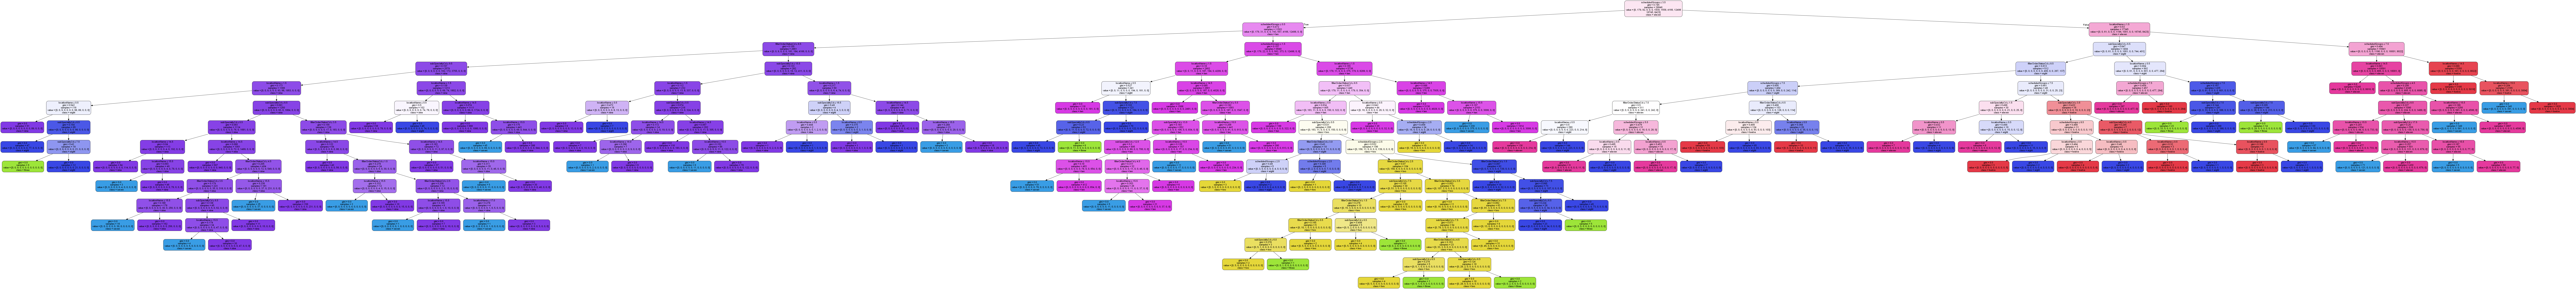

In [88]:
plot_decision_tree(estimator, x.columns,y.columns)

In [89]:
score = estimator.score(x, y)

In [90]:
score


0.9996052631578948

In [ ]:
query ="select test.subSpecialtyCd, test.fillerOrderStatusCd, test.locationName, test.scheduledGroups, CASE WHEN ISNULL(test.subSpecialtyCd, 'UNKNOWN') = '*GYP' AND test.locationName LIKE '%SPOKANE%' AND test.scheduledGroups = '1' AND test.fillerOrderStatusCd LIKE '%F%' THEN 1 WHEN ISNULL(test.subSpecialtyCd, 'UNKNOWN') NOT LIKE '*GYP' AND test.locationName LIKE '%SPOKANE%' AND test.scheduledGroups = '3' THEN 2 WHEN ISNULL(test.subSpecialtyCd, 'UNKNOWN') LIKE '*GYP' AND test.locationName LIKE '%SPOKANE%' THEN 3 WHEN ISNULL(test.subSpecialtyCd, 'UNKNOWN') LIKE '*GP' AND test.locationName LIKE '%BELLEVUE%' AND test.scheduledGroups = '3' AND test.fillerOrderStatusCd LIKE '%F%' THEN 4 WHEN ISNULL(test.subSpecialtyCd, 'UNKNOWN') LIKE '*GYP' AND test.locationName LIKE '%BELLEVUE%' AND test.scheduledGroups = '1' AND test.fillerOrderStatusCd LIKE '%C%' THEN 5 WHEN ISNULL(test.subSpecialtyCd, 'UNKNOWN') LIKE '*GYP' AND test.locationName LIKE '%BELLEVUE%' AND test.scheduledGroups = '1' AND test.fillerOrderStatusCd LIKE '%F%' THEN 6 WHEN test.locationName LIKE '%BELLEVUE%' THEN 7 WHEN test.locationName LIKE '%SPOKANE%' THEN 8 WHEN test.scheduledGroups = '1' THEN 9 WHEN test.scheduledGroups = '2' OR test.scheduledGroups = '3' OR test.scheduledGroups = '4' THEN 10 WHEN test.scheduledGroups = '5' OR test.scheduledGroups = '6' OR test.scheduledGroups = '7' OR test.scheduledGroups = '8' THEN 11 ELSE 12 END as bucketName from ( SELECT ISNULL( ProcedureStep.subSpecialtyCd, 'UNKNOWN' ) AS subSpecialtyCd, ISNULL( FillerOrder.fillerOrderStatusCd, 'UNKNOWN' ) as fillerOrderStatusCd, ISNULL(PL.locationName, 'UNKNOWN') as locationName, case when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 465 then 1 when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 562 then 2 when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 664 then 3 when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 762 then 4 when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 860 then 5 when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 955 then 6 when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 1056 then 7 when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 1153 then 8 when DATEDIFF( DAY, FillerOrder.scheduled, GETDATE() ) <= 1247 then 9 else 10 end as scheduledGroups FROM ProcedureStep LEFT JOIN RequestedProcedure ON ProcedureStep.requestedProcedureKey = RequestedProcedure.requestedProcedureKey LEFT JOIN FillerOrder ON RequestedProcedure.fillerOrderKey = FillerOrder.fillerOrderKey LEFT JOIN LOCATION AS PL ON FillerOrder.scheduledLocationKey = PL.locationKey ) as test"
original1 = getData(server, UID, PWD, database,query)
data1 = original1.copy()
data1['subSpecialtyCd'] = data1.subSpecialtyCd.apply(lambda x: np.where(subSpecialtyCd.values == x)[0][0])
data1['fillerOrderStatusCd'] = data1.fillerOrderStatusCd.apply(lambda x: np.where(fillerOrderStatusCd.values == x)[0][0])
data1['locationName'] = data1.locationName.apply(lambda x: np.where(locationNameCd.values == x)[0][0])
data1['scheduledGroups'] = data1.scheduledGroups.apply(lambda x: np.where(scheduledGroups == x)[0][0])

data1['bucketName'] = data1.bucketName.apply(lambda x: np.where(bucketNumCd == x)[0][0])
#create the test input set based on the three params
x_test = data1[['subSpecialtyCd', 'fillerOrderStatusCd', 'locationName', 'scheduledGroups' ]]

#create the test labels set
y_test = data1[['bucketName']]
score2 = estimator.score(x_test, y_test)
score2